# Training on all BENGI datasets

In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
from xgboost import plot_importance
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
#from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from numpy import sort

In [1]:
!uname -r

5.15.94.mx64.447


In [3]:
def optimalparamsearch(com):
    com['distance'] =com['distance'].abs()
    com=com.sort_values('pair19')
    com=com.reset_index(drop=True)
    ''' function to do parameter search '''
    cv_names=com["CV"].unique()
    myCViterator = []
    for i in range(len(cv_names)):
        trainIndices = com[ com['CV']!=cv_names[i] ].index.values.astype(int)
        testIndices =  com[ com['CV']==cv_names[i] ].index.values.astype(int)
        myCViterator.append( (trainIndices, testIndices) )


    #run randomized search for optimal parameters

    X_train= com.drop(['gene_id1','gene_id','symbol38','symbol19','pair','pair19','label','CV'], axis=1).copy()
    y_train = com['label'].copy()
    model = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0)
    param_grid = {
            'max_depth': [4, 5, 6,8,10,12],
            'learning_rate': [0.1, 0.05, 0.01],
            'gamma': [0, 0.25, 1.0],
            'reg_lambda': [0, 1.0, 10.0],
            'n_estimators': [100,200,300,400,500],
            'colsample_bytree': [0.5,0.6,0.7,0.9],
            'subsample': [0.7, 0.9]
        }
    search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,scoring='f1', cv=myCViterator, n_jobs=12, refit=True)
    result = search.fit(X_train, y_train)
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    return(result.best_score_, result.best_params_)

In [7]:
def trainOptParams(com, best_params, pathtomodel):
    X_train_xg= com.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
    y_train_xg = com['label'].copy()
    clf_xgb = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params)
    clf_xgb.fit(X_train_xg, y_train_xg)
    clf_xgb.save_model(pathtomodel)
    return(clf_xgb)

In [8]:
def makeFeatImpPlot(clf_xgb, sample, pathtopic):
    clf_xgb.get_booster().feature_names= ["CRUP-EP enhancer 1", "CRUP-EP enhancer 2", "CRUP-EP enhancer 3", "CRUP-EP enhancer 4",
                                     "CRUP-EP enhancer 5","CRUP-EP promoter 1","CRUP-EP promoter 2","CRUP-EP promoter 3",
                                     "CRUP-EP promoter 4","CRUP-EP promoter 5","CRUP-PP enhancer 1", "CRUP-PP enhancer 2", 
                                      "CRUP-PP enhancer 3", "CRUP-PP enhancer 4",
                                     "CRUP-PP enhancer 5","CRUP-PP promoter 1","CRUP-PP promoter 2","CRUP-PP promoter 3",
                                     "CRUP-PP promoter 4","CRUP-PP promoter 5","Genomic distance","CRUP correlation",
                                     "Wilcoxon tests combined","Regulatory distance\n enhancers",
                                      "Normalized Regulatory\n distance enhancers","Regulatory distance\n promoters",
                                      "Normalized Regulatory\n distance promoters", "RNA-seq", "Minimum Insulation", "Mean Switch Intensity"]

    fig1=plot_importance(clf_xgb,xlabel="number of times a feature appears in a tree",show_values=False,
                         title= "Feature importance CENTRE.MI.MSI " + sample,ylabel=None,max_num_features=10)
    pyplot.show()
    fig1.figure.tight_layout()
    fig1.figure.savefig(pathtopic, 
                 dpi=300,orientation='landscape',format='png',facecolor='white')
    return(0)

In [21]:
def CVF1results(com, com1, best_params, best_params1):

    cv_names=com["CV"].unique()
    d = dict(tuple(com.groupby('CV')))
    d1 = dict(tuple(com1.groupby('CV')))
    result_all_xgboost={}
    result_all_tf={}
    result_cv_xg=[]
    result_cv_tf=[]
    for i in range(len(cv_names)):
        cv_test=cv_names[i]
        cv_train=[x for k,x in enumerate(cv_names) if k!=i]
        X_test_xg = d[cv_test].drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
        y_test_xg = d[cv_test]['label'].copy()
        train_xg=pd.concat({k: d[k] for k in cv_train})
        X_train_xg= train_xg.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
        y_train_xg = train_xg['label'].copy()
        clf_xgb = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params)
        clf_xgb.fit(X_train_xg, y_train_xg)
        pred_s = clf_xgb.predict_proba(X_test_xg)
        lr_probs =pred_s[:, 1]
        yhat = clf_xgb.predict(X_test_xg)
        result_cv = pd.DataFrame({'pred_prob':lr_probs,'pred_label': yhat,'true_label':y_test_xg})
        result_cv_xg.append(f1_score(result_cv['true_label'], result_cv['pred_label']))
        result_all_xgboost[cv_test]=result_cv
        
        X_test_tf = d1[cv_test].drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
        y_test_tf = d1[cv_test]['label'].copy()
        train_tf=pd.concat({k: d1[k] for k in cv_train})
        X_train_tf= train_tf.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
        y_train_tf = train_tf['label'].copy()
        clf_gb = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params1)
        clf_gb.fit(X_train_tf, y_train_tf)
        pred_s = clf_gb.predict_proba(X_test_tf)
        lr_probs =pred_s[:, 1]
        yhat = clf_gb.predict(X_test_tf)
        result_cv = pd.DataFrame({'pred_prob':lr_probs,'pred_label': yhat,'true_label':y_test_tf})
        result_cv_tf.append(f1_score(result_cv['true_label'], result_cv['pred_label']))
        result_all_tf[cv_test]=result_cv



    results_xg=pd.concat(result_all_xgboost)
    
    lr_precision_xg, lr_recall_xg, _ = precision_recall_curve(results_xg['true_label'], results_xg['pred_prob'])
    lr_f1_xg, lr_auc_xg = f1_score(results_xg['true_label'], results_xg['pred_label']), auc(lr_recall_xg, lr_precision_xg)
    print('xgboost HiC 12 fold CV:auc=%.3f' % lr_auc_xg)
    print(lr_f1_xg)
    print(result_cv_xg)


    results_tf=pd.concat(result_all_tf)
    lr_precision_tf, lr_recall_tf, _ = precision_recall_curve(results_tf['true_label'], results_tf['pred_prob'])
    lr_f1_tf, lr_auc_tf = f1_score(results_tf['true_label'], results_tf['pred_label'], average = None), auc(lr_recall_tf, lr_precision_tf)
    print('CENTRE 12 fold CV: auc=%.3f' % lr_auc_tf)
    print(lr_f1_tf)
    print(result_cv_tf)
    dist_precision, dist_recall, _=precision_recall_curve(com['label'],1/abs(com['distance']))
    dist_auc = auc(dist_recall, dist_precision)
    print('Distance:auc=%.3f' % (dist_auc))
    ##1st f1 scores of CENTRE.MSI.MI
    ##2nd f1 scores of CENTRE
    return(lr_f1_xg, lr_f1_tf, result_cv_xg, result_cv_tf)

In [5]:
### This is where the script starts

##General paths and suffixes
suffixMIMSI = "-Benchmark.MI.MSI.v38.csv"
suffixBENGI = "-Benchmark.v38.txt"
rootMIMSI = "/project/CRUP_scores/CENTRE_HiC/Training/BENGI_MSI_MI_datasets/"
rootBENGI = "/project/CRUP_scores/toSara/BENGI_processed_datasets/"

(26983, 38)
(26983, 36)
est=0.333, cfg={'subsample': 0.7, 'reg_lambda': 10.0, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 1.0, 'colsample_bytree': 0.6}
est=0.334, cfg={'subsample': 0.7, 'reg_lambda': 0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:00:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


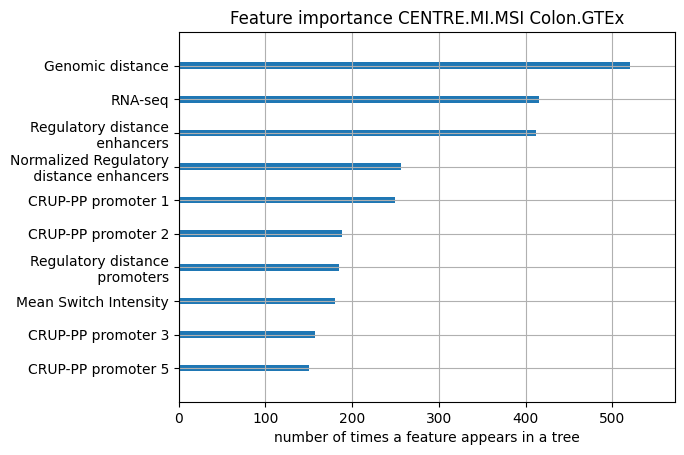

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:00:57] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.229
[0.96416302 0.32845647]
CENTRE 12 fold CV: auc=0.226
[0.96662518 0.32705882]
Distance:auc=0.130


In [18]:
#Colon.GTEx
sample = "Colon.GTEx"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+sample+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV



In [22]:
f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV = CVF1results(com, com1, best_params, best_params1)

xgboost HiC 12 fold CV:auc=0.229
0.3284564740307242
[0.3017241379310345, 0.3125, 0.22145328719723184, 0.4744186046511628, 0.30909090909090914, 0.27317073170731704, 0.2867924528301887, 0.4111111111111111, 0.33043478260869563, 0.323943661971831, 0.3615819209039548, 0.40375586854460094]
CENTRE 12 fold CV: auc=0.226
[0.96662518 0.32705882]
[0.3098591549295775, 0.29126213592233, 0.20074349442379183, 0.518867924528302, 0.31775700934579443, 0.29441624365482233, 0.2903225806451613, 0.4186046511627907, 0.3148148148148148, 0.26356589147286824, 0.3544303797468355, 0.4385026737967914]
Distance:auc=0.130


In [23]:
f1data = pd.DataFrame()
### columns = Sample, f1-scores
f1data['SampleName'] = [sample]*24
f1data['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
print(f1data)

    SampleName          Model        f1
0   Colon.GTEx  CENTRE.MI.MSI  0.301724
1   Colon.GTEx  CENTRE.MI.MSI  0.312500
2   Colon.GTEx  CENTRE.MI.MSI  0.221453
3   Colon.GTEx  CENTRE.MI.MSI  0.474419
4   Colon.GTEx  CENTRE.MI.MSI  0.309091
5   Colon.GTEx  CENTRE.MI.MSI  0.273171
6   Colon.GTEx  CENTRE.MI.MSI  0.286792
7   Colon.GTEx  CENTRE.MI.MSI  0.411111
8   Colon.GTEx  CENTRE.MI.MSI  0.330435
9   Colon.GTEx  CENTRE.MI.MSI  0.323944
10  Colon.GTEx  CENTRE.MI.MSI  0.361582
11  Colon.GTEx  CENTRE.MI.MSI  0.403756
12  Colon.GTEx         CENTRE  0.309859
13  Colon.GTEx         CENTRE  0.291262
14  Colon.GTEx         CENTRE  0.200743
15  Colon.GTEx         CENTRE  0.518868
16  Colon.GTEx         CENTRE  0.317757
17  Colon.GTEx         CENTRE  0.294416
18  Colon.GTEx         CENTRE  0.290323
19  Colon.GTEx         CENTRE  0.418605
20  Colon.GTEx         CENTRE  0.314815
21  Colon.GTEx         CENTRE  0.263566
22  Colon.GTEx         CENTRE  0.354430
23  Colon.GTEx         CENTRE  0.438503


(283632, 38)
(283632, 36)
est=0.584, cfg={'subsample': 0.9, 'reg_lambda': 0, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 1.0, 'colsample_bytree': 0.7}


/pkg/python-3.10.12-0/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


est=0.593, cfg={'subsample': 0.7, 'reg_lambda': 1.0, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 1.0, 'colsample_bytree': 0.9}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:22:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


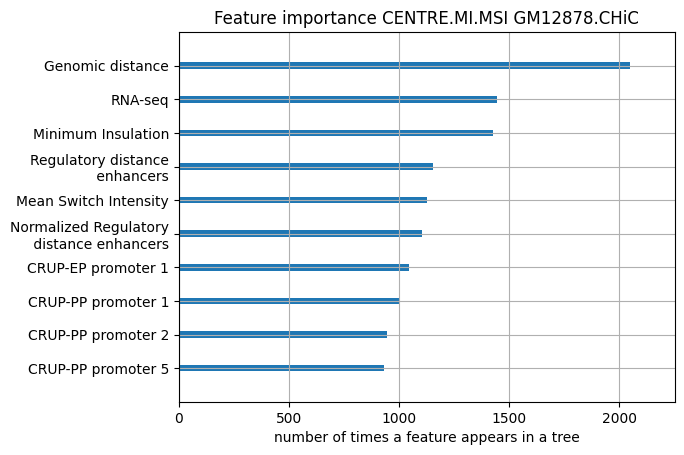

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:22:34] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.605
0.5843648039774197
[0.5372752209692168, 0.6043785935426802, 0.5891280353200884, 0.5990886174132247, 0.569650214780398, 0.6206621459912246, 0.6026516042990508, 0.5862598349644982, 0.581973445633737, 0.5748820075975596, 0.5714552412956221, 0.5785637936060636]
CENTRE 12 fold CV: auc=0.591
[0.87293458 0.59060293]
[0.5570904990132507, 0.6261176174285354, 0.5952172876777628, 0.5914422969500615, 0.5824575586095393, 0.6225153595952294, 0.5962432915921289, 0.5973652164286506, 0.5772005772005772, 0.5891352262414106, 0.5913118651393992, 0.5821357506080035]
Distance:auc=0.288


In [24]:
#GM12878.CHiC
sample = "GM12878.CHiC"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+sample+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV

f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV = CVF1results(com, com1, best_params, best_params1)


In [26]:
f1data2 = pd.DataFrame()
### columns = Sample, f1-scores
f1data2['SampleName'] = [sample]*24
f1data2['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data2['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
f1data = pd.concat([f1data, f1data2], ignore_index = True)
print(f1data)

      SampleName          Model        f1
0     Colon.GTEx  CENTRE.MI.MSI  0.301724
1     Colon.GTEx  CENTRE.MI.MSI  0.312500
2     Colon.GTEx  CENTRE.MI.MSI  0.221453
3     Colon.GTEx  CENTRE.MI.MSI  0.474419
4     Colon.GTEx  CENTRE.MI.MSI  0.309091
5     Colon.GTEx  CENTRE.MI.MSI  0.273171
6     Colon.GTEx  CENTRE.MI.MSI  0.286792
7     Colon.GTEx  CENTRE.MI.MSI  0.411111
8     Colon.GTEx  CENTRE.MI.MSI  0.330435
9     Colon.GTEx  CENTRE.MI.MSI  0.323944
10    Colon.GTEx  CENTRE.MI.MSI  0.361582
11    Colon.GTEx  CENTRE.MI.MSI  0.403756
12    Colon.GTEx         CENTRE  0.309859
13    Colon.GTEx         CENTRE  0.291262
14    Colon.GTEx         CENTRE  0.200743
15    Colon.GTEx         CENTRE  0.518868
16    Colon.GTEx         CENTRE  0.317757
17    Colon.GTEx         CENTRE  0.294416
18    Colon.GTEx         CENTRE  0.290323
19    Colon.GTEx         CENTRE  0.418605
20    Colon.GTEx         CENTRE  0.314815
21    Colon.GTEx         CENTRE  0.263566
22    Colon.GTEx         CENTRE  0

(80965, 38)
(80965, 36)
est=0.420, cfg={'subsample': 0.7, 'reg_lambda': 0, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}
est=0.420, cfg={'subsample': 0.7, 'reg_lambda': 0, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 0.5}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:31:20] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


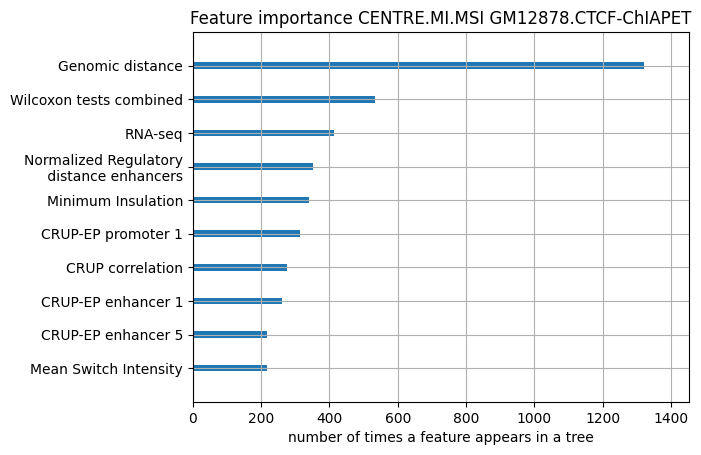

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:31:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.367
0.4163959010247439
[0.40870488322717624, 0.5025125628140703, 0.353021978021978, 0.4373956594323873, 0.4208664898320071, 0.4410339256865913, 0.4666177549523111, 0.3942953020134228, 0.387140902872777, 0.39619883040935666, 0.4028268551236749, 0.42787046123650635]
CENTRE 12 fold CV: auc=0.360
[0.94293268 0.41622746]
[0.4155542658154382, 0.48598130841121495, 0.3527675276752768, 0.44402985074626866, 0.43326488706365507, 0.4256880733944954, 0.4700082169268694, 0.4168962350780533, 0.40273556231003044, 0.3694581280788177, 0.4032869785082175, 0.415948275862069]
Distance:auc=0.177


In [27]:
#GM12878.CTCF"
sample = "GM12878.CTCF-ChIAPET"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+sample+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV

f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV  = CVF1results(com, com1, best_params, best_params1)

In [28]:
f1data2 = pd.DataFrame()
### columns = Sample, f1-scores
f1data2['SampleName'] = [sample]*24
f1data2['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data2['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
f1data = pd.concat([f1data, f1data2], ignore_index = True)
print(f1data)

              SampleName          Model        f1
0             Colon.GTEx  CENTRE.MI.MSI  0.301724
1             Colon.GTEx  CENTRE.MI.MSI  0.312500
2             Colon.GTEx  CENTRE.MI.MSI  0.221453
3             Colon.GTEx  CENTRE.MI.MSI  0.474419
4             Colon.GTEx  CENTRE.MI.MSI  0.309091
..                   ...            ...       ...
67  GM12878.CTCF-ChIAPET         CENTRE  0.416896
68  GM12878.CTCF-ChIAPET         CENTRE  0.402736
69  GM12878.CTCF-ChIAPET         CENTRE  0.369458
70  GM12878.CTCF-ChIAPET         CENTRE  0.403287
71  GM12878.CTCF-ChIAPET         CENTRE  0.415948

[72 rows x 3 columns]


(43288, 38)
(43288, 36)
est=0.391, cfg={'subsample': 0.7, 'reg_lambda': 0, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 1.0, 'colsample_bytree': 0.6}
est=0.380, cfg={'subsample': 0.9, 'reg_lambda': 10.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:35:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


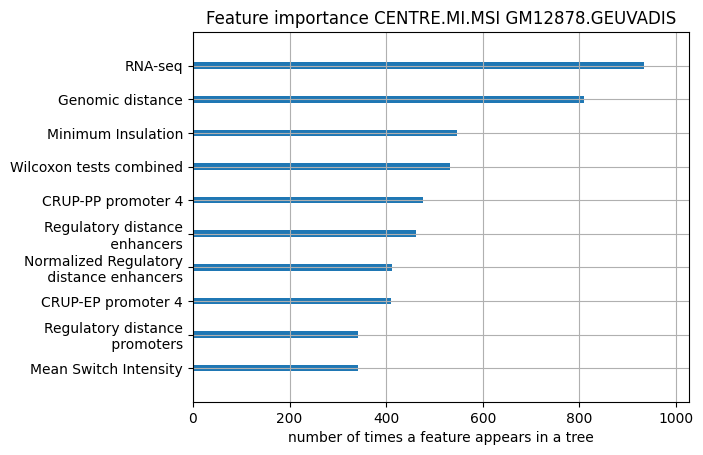

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:35:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.313
0.38294314381270905
[0.4210526315789474, 0.4823151125401929, 0.33990147783251234, 0.3214285714285714, 0.4949494949494949, 0.3830845771144279, 0.2780952380952381, 0.4, 0.3472222222222222, 0.4728434504792332, 0.3870967741935484, 0.3385214007782101]
CENTRE 12 fold CV: auc=0.303
[0.96118553 0.37470356]
[0.4074766355140187, 0.46451612903225803, 0.37037037037037035, 0.34055727554179566, 0.4786729857819905, 0.36717062634989195, 0.287719298245614, 0.37037037037037035, 0.3340857787810384, 0.4904458598726114, 0.38383838383838387, 0.29411764705882354]
Distance:auc=0.174


In [29]:

sample = "GM12878.GEUVADIS"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+sample+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV

f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV  = CVF1results(com, com1, best_params, best_params1)

In [30]:
f1data2 = pd.DataFrame()
### columns = Sample, f1-scores
f1data2['SampleName'] = [sample]*24
f1data2['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data2['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
f1data = pd.concat([f1data, f1data2], ignore_index = True)
print(f1data)

          SampleName          Model        f1
0         Colon.GTEx  CENTRE.MI.MSI  0.301724
1         Colon.GTEx  CENTRE.MI.MSI  0.312500
2         Colon.GTEx  CENTRE.MI.MSI  0.221453
3         Colon.GTEx  CENTRE.MI.MSI  0.474419
4         Colon.GTEx  CENTRE.MI.MSI  0.309091
..               ...            ...       ...
91  GM12878.GEUVADIS         CENTRE  0.370370
92  GM12878.GEUVADIS         CENTRE  0.334086
93  GM12878.GEUVADIS         CENTRE  0.490446
94  GM12878.GEUVADIS         CENTRE  0.383838
95  GM12878.GEUVADIS         CENTRE  0.294118

[96 rows x 3 columns]


(35189, 38)
(35189, 36)
est=0.298, cfg={'subsample': 0.7, 'reg_lambda': 1.0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 0.5}
est=0.278, cfg={'subsample': 0.7, 'reg_lambda': 0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 0.7}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:38:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


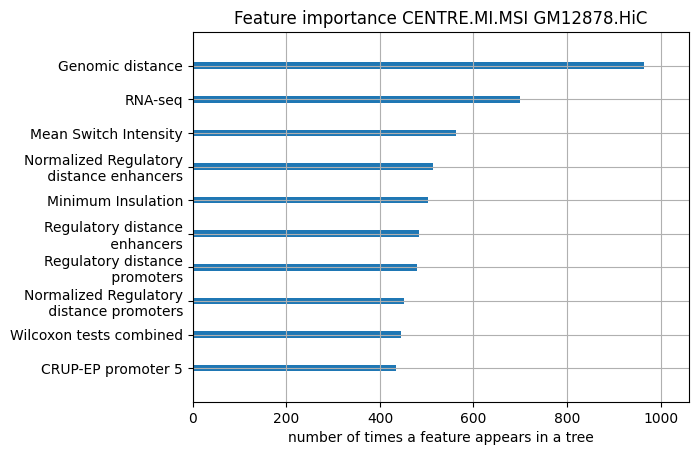

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:38:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.231
0.29975955116216935
[0.2824858757062147, 0.3553299492385787, 0.19327731092436976, 0.3461538461538462, 0.4405797101449275, 0.3300970873786408, 0.3157894736842105, 0.24683544303797467, 0.34909090909090906, 0.2551928783382789, 0.2247191011235955, 0.25]
CENTRE 12 fold CV: auc=0.227
[0.96434427 0.27339004]
[0.2271714922048998, 0.313953488372093, 0.23893805309734514, 0.2568093385214008, 0.3595505617977528, 0.3260869565217391, 0.2661596958174905, 0.26299694189602446, 0.3225806451612903, 0.2926829268292683, 0.19123505976095614, 0.26022304832713755]
Distance:auc=0.064


In [32]:
sample = "GM12878.HiC"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+"GM12878_HiC"+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV

f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV  = CVF1results(com, com1, best_params, best_params1)

In [33]:
f1data2 = pd.DataFrame()
### columns = Sample, f1-scores
f1data2['SampleName'] = [sample]*24
f1data2['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data2['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
f1data = pd.concat([f1data, f1data2], ignore_index = True)
print(f1data)

      SampleName          Model        f1
0     Colon.GTEx  CENTRE.MI.MSI  0.301724
1     Colon.GTEx  CENTRE.MI.MSI  0.312500
2     Colon.GTEx  CENTRE.MI.MSI  0.221453
3     Colon.GTEx  CENTRE.MI.MSI  0.474419
4     Colon.GTEx  CENTRE.MI.MSI  0.309091
..           ...            ...       ...
115  GM12878.HiC         CENTRE  0.262997
116  GM12878.HiC         CENTRE  0.322581
117  GM12878.HiC         CENTRE  0.292683
118  GM12878.HiC         CENTRE  0.191235
119  GM12878.HiC         CENTRE  0.260223

[120 rows x 3 columns]


(116429, 38)
(116429, 36)
est=0.641, cfg={'subsample': 0.9, 'reg_lambda': 0, 'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}
est=0.644, cfg={'subsample': 0.7, 'reg_lambda': 10.0, 'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 1.0, 'colsample_bytree': 0.6}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:48:07] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


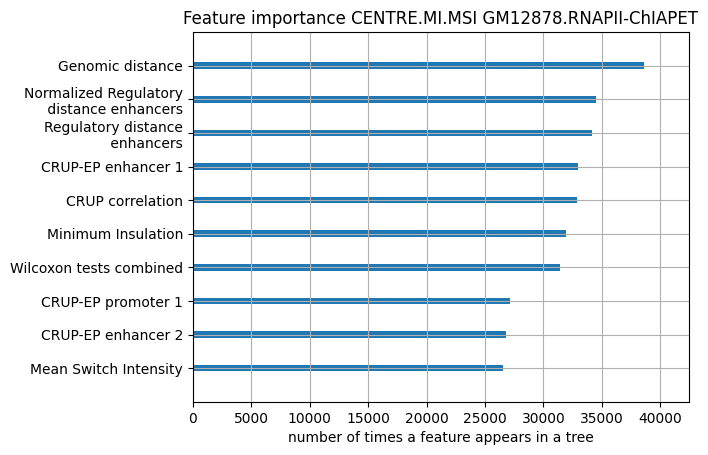

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:48:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.699
0.639487164125453
[0.627750073335289, 0.6225626740947077, 0.6026926382125467, 0.6179146256123165, 0.6523848019401779, 0.6707882534775887, 0.6652675760755509, 0.6353653918970087, 0.6194423511680482, 0.6560846560846559, 0.6478978978978979, 0.6779801324503311]
CENTRE 12 fold CV: auc=0.700
[0.93892999 0.64165634]
[0.6261925411968777, 0.6290158944876564, 0.5966639321848509, 0.6165311653116531, 0.6718878812860676, 0.6758515116724072, 0.6648389307745032, 0.64097672644029, 0.6164688427299703, 0.6590538336052202, 0.6461086637298091, 0.6886055121349239]
Distance:auc=0.339


In [34]:
sample = "GM12878.RNAPII-ChIAPET"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+sample+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV

f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV = CVF1results(com, com1, best_params, best_params1)

In [35]:
f1data2 = pd.DataFrame()
### columns = Sample, f1-scores
f1data2['SampleName'] = [sample]*24
f1data2['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data2['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
f1data = pd.concat([f1data, f1data2], ignore_index = True)
print(f1data)

                 SampleName          Model        f1
0                Colon.GTEx  CENTRE.MI.MSI  0.301724
1                Colon.GTEx  CENTRE.MI.MSI  0.312500
2                Colon.GTEx  CENTRE.MI.MSI  0.221453
3                Colon.GTEx  CENTRE.MI.MSI  0.474419
4                Colon.GTEx  CENTRE.MI.MSI  0.309091
..                      ...            ...       ...
139  GM12878.RNAPII-ChIAPET         CENTRE  0.640977
140  GM12878.RNAPII-ChIAPET         CENTRE  0.616469
141  GM12878.RNAPII-ChIAPET         CENTRE  0.659054
142  GM12878.RNAPII-ChIAPET         CENTRE  0.646109
143  GM12878.RNAPII-ChIAPET         CENTRE  0.688606

[144 rows x 3 columns]


In [36]:
df.to_csv('/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/f1_temp.csv')

(25564, 38)
(25564, 36)
est=0.400, cfg={'subsample': 0.9, 'reg_lambda': 10.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
est=0.398, cfg={'subsample': 0.7, 'reg_lambda': 10.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:16:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


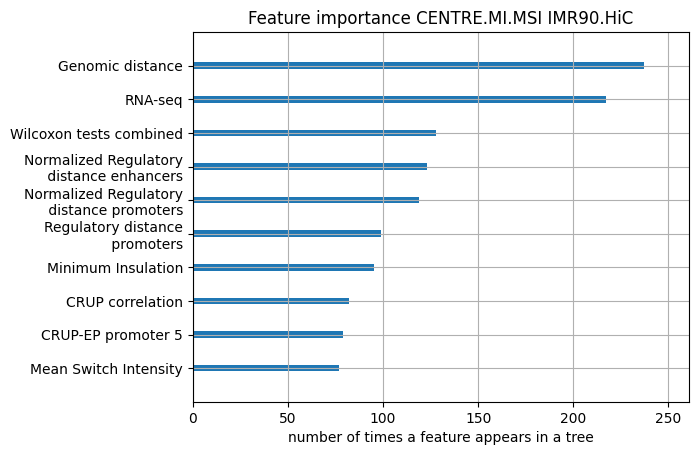

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:16:52] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.364
0.3946293053123176
[0.28840125391849536, 0.4679245283018868, 0.33676975945017185, 0.33774834437086093, 0.45245901639344266, 0.3564356435643565, 0.4444444444444444, 0.42647058823529416, 0.3947368421052632, 0.4387096774193548, 0.3925233644859813, 0.42500000000000004]
CENTRE 12 fold CV: auc=0.352
[0.96622947 0.39734611]
[0.2893617021276596, 0.46445497630331756, 0.40740740740740744, 0.32539682539682546, 0.4365079365079365, 0.33191489361702126, 0.41666666666666663, 0.48372093023255813, 0.3777777777777777, 0.40869565217391307, 0.3940520446096655, 0.4554455445544554]
Distance:auc=0.073


In [37]:
sample = "IMR90.HiC"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+sample+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV

f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV = CVF1results(com, com1, best_params, best_params1)

In [38]:
f1data2 = pd.DataFrame()
### columns = Sample, f1-scores
f1data2['SampleName'] = [sample]*24
f1data2['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data2['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
f1data = pd.concat([f1data, f1data2], ignore_index = True)
print(f1data)

     SampleName          Model        f1
0    Colon.GTEx  CENTRE.MI.MSI  0.301724
1    Colon.GTEx  CENTRE.MI.MSI  0.312500
2    Colon.GTEx  CENTRE.MI.MSI  0.221453
3    Colon.GTEx  CENTRE.MI.MSI  0.474419
4    Colon.GTEx  CENTRE.MI.MSI  0.309091
..          ...            ...       ...
163   IMR90.HiC         CENTRE  0.483721
164   IMR90.HiC         CENTRE  0.377778
165   IMR90.HiC         CENTRE  0.408696
166   IMR90.HiC         CENTRE  0.394052
167   IMR90.HiC         CENTRE  0.455446

[168 rows x 3 columns]


(13961, 38)
(13961, 36)
est=0.550, cfg={'subsample': 0.7, 'reg_lambda': 0, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}
est=0.541, cfg={'subsample': 0.9, 'reg_lambda': 10.0, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 1.0, 'colsample_bytree': 0.7}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:24:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


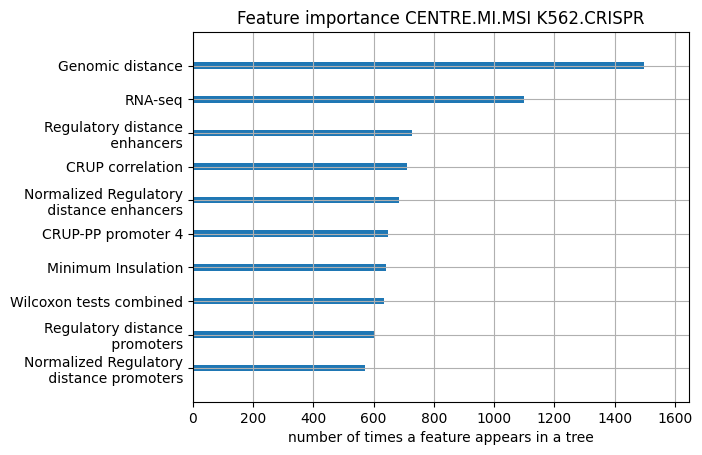

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:24:59] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.533
0.5312208760484622
[0.5849056603773585, 0.6052631578947368, 0.42857142857142855, 0.379746835443038, 0.4247787610619469, 0.6301369863013699, 0.47311827956989244, 0.4000000000000001, 0.5882352941176471, 0.6352941176470588, 0.6216216216216216, 0.6728971962616823]
CENTRE 12 fold CV: auc=0.514
[0.97836016 0.52310231]
[0.5365853658536586, 0.6526315789473683, 0.37894736842105264, 0.3373493975903615, 0.4247787610619469, 0.675, 0.44642857142857145, 0.4172661870503597, 0.5641025641025641, 0.6373626373626373, 0.6666666666666665, 0.6229508196721312]
Distance:auc=0.252


In [39]:
sample = "K562.CRISPR"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+sample+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV

f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV = CVF1results(com, com1, best_params, best_params1)

In [40]:
f1data2 = pd.DataFrame()
### columns = Sample, f1-scores
f1data2['SampleName'] = [sample]*24
f1data2['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data2['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
f1data = pd.concat([f1data, f1data2], ignore_index = True)
print(f1data)

      SampleName          Model        f1
0     Colon.GTEx  CENTRE.MI.MSI  0.301724
1     Colon.GTEx  CENTRE.MI.MSI  0.312500
2     Colon.GTEx  CENTRE.MI.MSI  0.221453
3     Colon.GTEx  CENTRE.MI.MSI  0.474419
4     Colon.GTEx  CENTRE.MI.MSI  0.309091
..           ...            ...       ...
187  K562.CRISPR         CENTRE  0.417266
188  K562.CRISPR         CENTRE  0.564103
189  K562.CRISPR         CENTRE  0.637363
190  K562.CRISPR         CENTRE  0.666667
191  K562.CRISPR         CENTRE  0.622951

[192 rows x 3 columns]


(27079, 38)
(27079, 36)
est=0.100, cfg={'subsample': 0.7, 'reg_lambda': 1.0, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 1.0, 'colsample_bytree': 0.5}
est=0.107, cfg={'subsample': 0.7, 'reg_lambda': 10.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 1.0, 'colsample_bytree': 0.7}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:34:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


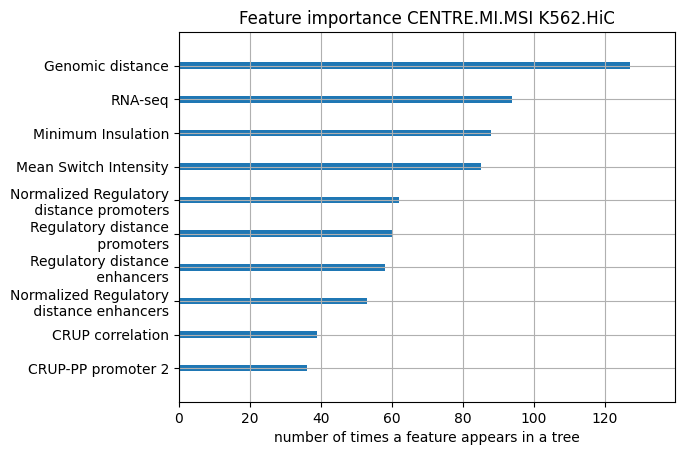

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:34:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.133
0.11390728476821194
[0.1142857142857143, 0.05263157894736842, 0.08849557522123894, 0.14814814814814814, 0.08130081300813008, 0.12389380530973454, 0.2037037037037037, 0.051546391752577324, 0.1643835616438356, 0.11009174311926605, 0.14432989690721648, 0.1694915254237288]
CENTRE 12 fold CV: auc=0.115
[0.97201919 0.09371147]
[0.06986899563318777, 0.07142857142857144, 0.08633093525179857, 0.08955223880597014, 0.016260162601626015, 0.14414414414414414, 0.1801801801801802, 0.11818181818181818, 0.2, 0.032786885245901634, 0.1081081081081081, 0.07142857142857142]
Distance:auc=0.053


In [41]:
sample = "K562.HiC"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+sample+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV

f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV = CVF1results(com, com1, best_params, best_params1)

In [42]:
f1data2 = pd.DataFrame()
### columns = Sample, f1-scores
f1data2['SampleName'] = [sample]*24
f1data2['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data2['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
f1data = pd.concat([f1data, f1data2], ignore_index = True)
print(f1data)

     SampleName          Model        f1
0    Colon.GTEx  CENTRE.MI.MSI  0.301724
1    Colon.GTEx  CENTRE.MI.MSI  0.312500
2    Colon.GTEx  CENTRE.MI.MSI  0.221453
3    Colon.GTEx  CENTRE.MI.MSI  0.474419
4    Colon.GTEx  CENTRE.MI.MSI  0.309091
..          ...            ...       ...
211    K562.HiC         CENTRE  0.118182
212    K562.HiC         CENTRE  0.200000
213    K562.HiC         CENTRE  0.032787
214    K562.HiC         CENTRE  0.108108
215    K562.HiC         CENTRE  0.071429

[216 rows x 3 columns]


(13789, 38)
(13789, 36)
est=0.293, cfg={'subsample': 0.9, 'reg_lambda': 10.0, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}
est=0.304, cfg={'subsample': 0.9, 'reg_lambda': 0, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 0.6}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:41:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


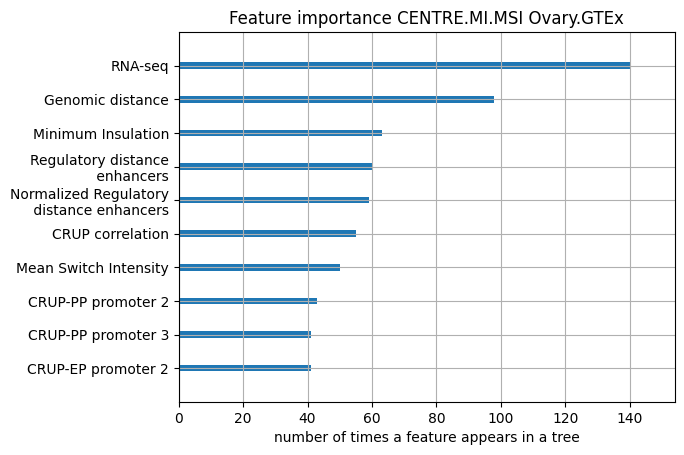

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:41:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.209
0.2833333333333333
[0.22222222222222224, 0.275, 0.26, 0.3384615384615384, 0.3190184049079755, 0.22857142857142856, 0.3119266055045872, 0.2601626016260163, 0.2912621359223301, 0.34782608695652173, 0.1891891891891892, 0.3564356435643565]
CENTRE 12 fold CV: auc=0.219
[0.96933212 0.30531732]
[0.22641509433962262, 0.3513513513513514, 0.31683168316831684, 0.33333333333333337, 0.33548387096774196, 0.23300970873786409, 0.336283185840708, 0.3025210084033613, 0.3298969072164949, 0.3283582089552239, 0.19178082191780824, 0.3673469387755102]
Distance:auc=0.133


In [44]:
sample = "Ovary.GTEx"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+sample+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV

f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV = CVF1results(com, com1, best_params, best_params1)

In [45]:
f1data2 = pd.DataFrame()
### columns = Sample, f1-scores
f1data2['SampleName'] = [sample]*24
f1data2['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data2['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
f1data = pd.concat([f1data, f1data2], ignore_index = True)
print(f1data)

     SampleName          Model        f1
0    Colon.GTEx  CENTRE.MI.MSI  0.301724
1    Colon.GTEx  CENTRE.MI.MSI  0.312500
2    Colon.GTEx  CENTRE.MI.MSI  0.221453
3    Colon.GTEx  CENTRE.MI.MSI  0.474419
4    Colon.GTEx  CENTRE.MI.MSI  0.309091
..          ...            ...       ...
235  Ovary.GTEx         CENTRE  0.302521
236  Ovary.GTEx         CENTRE  0.329897
237  Ovary.GTEx         CENTRE  0.328358
238  Ovary.GTEx         CENTRE  0.191781
239  Ovary.GTEx         CENTRE  0.367347

[240 rows x 3 columns]


(43357, 38)
(43357, 36)
est=0.382, cfg={'subsample': 0.9, 'reg_lambda': 0, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.9}
est=0.380, cfg={'subsample': 0.9, 'reg_lambda': 1.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.9}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:50:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


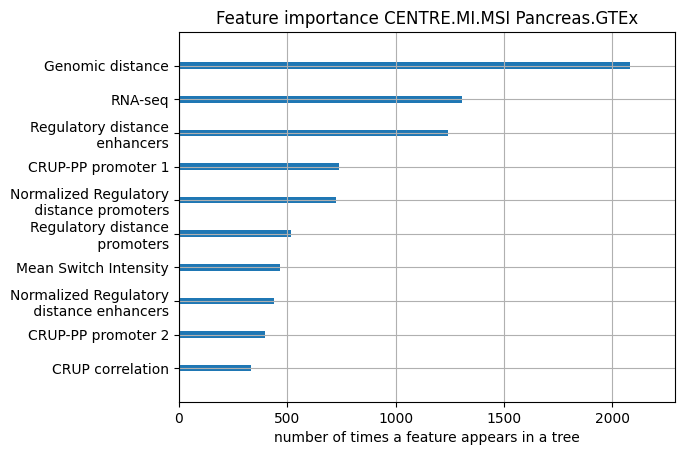

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:50:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.295
0.38243402914533275
[0.3811881188118812, 0.36111111111111105, 0.3981264637002342, 0.41217798594847777, 0.3061630218687873, 0.4524886877828054, 0.2925851703406814, 0.3756708407871199, 0.4265927977839335, 0.36363636363636365, 0.4434968017057569, 0.3922518159806295]
CENTRE 12 fold CV: auc=0.298
[0.96410794 0.38010957]
[0.36856368563685643, 0.37354085603112835, 0.390745501285347, 0.3814432989690722, 0.31752577319587627, 0.4593301435406698, 0.29350104821802936, 0.3763837638376384, 0.45103857566765576, 0.3218390804597701, 0.44341801385681295, 0.3948717948717948]
Distance:auc=0.191


In [46]:
sample = "Pancreas.GTEx"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+sample+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV

f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV = CVF1results(com, com1, best_params, best_params1)

In [47]:
f1data2 = pd.DataFrame()
### columns = Sample, f1-scores
f1data2['SampleName'] = [sample]*24
f1data2['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data2['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
f1data = pd.concat([f1data, f1data2], ignore_index = True)
print(f1data)

        SampleName          Model        f1
0       Colon.GTEx  CENTRE.MI.MSI  0.301724
1       Colon.GTEx  CENTRE.MI.MSI  0.312500
2       Colon.GTEx  CENTRE.MI.MSI  0.221453
3       Colon.GTEx  CENTRE.MI.MSI  0.474419
4       Colon.GTEx  CENTRE.MI.MSI  0.309091
..             ...            ...       ...
259  Pancreas.GTEx         CENTRE  0.376384
260  Pancreas.GTEx         CENTRE  0.451039
261  Pancreas.GTEx         CENTRE  0.321839
262  Pancreas.GTEx         CENTRE  0.443418
263  Pancreas.GTEx         CENTRE  0.394872

[264 rows x 3 columns]


(35857, 38)
(35857, 36)
est=0.337, cfg={'subsample': 0.9, 'reg_lambda': 0, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 1.0, 'colsample_bytree': 0.9}
est=0.332, cfg={'subsample': 0.7, 'reg_lambda': 1.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 0.9}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:59:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


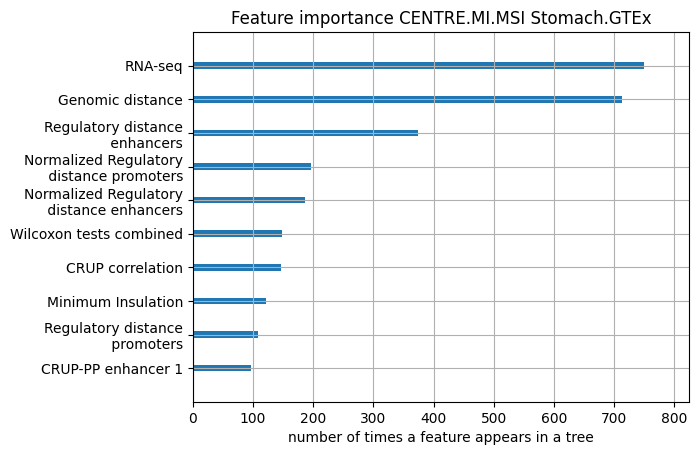

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:59:57] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.252
0.3335879806468042
[0.25396825396825395, 0.27350427350427353, 0.38, 0.30128205128205127, 0.28817204301075267, 0.2878787878787879, 0.32608695652173914, 0.431095406360424, 0.3365695792880259, 0.38596491228070173, 0.45210727969348663, 0.3644444444444444]
CENTRE 12 fold CV: auc=0.250
[0.9674269  0.32770066]
[0.23220973782771537, 0.2708333333333333, 0.35200000000000004, 0.2891566265060241, 0.3033419023136247, 0.3119266055045872, 0.2990033222591362, 0.3833333333333333, 0.35019455252918286, 0.38064516129032255, 0.4279475982532751, 0.37681159420289856]
Distance:auc=0.159


In [48]:
sample = "Stomach.GTEx"
centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (centreMSIMI.shape)


centre = pd.read_csv(rootBENGI+sample+suffixBENGI, 
                 header=0, sep='\t')
print (centre.shape)

##Parameter search
com=centreMSIMI.fillna(0)
com1=centre.fillna(0)
best_score, best_params = optimalparamsearch(com)
best_score1, best_params1 = optimalparamsearch(com1)

##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")
##CV

f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV = CVF1results(com, com1, best_params, best_params1)



In [49]:
f1data2 = pd.DataFrame()
### columns = Sample, f1-scores
f1data2['SampleName'] = [sample]*24
f1data2['Model'] = ["CENTRE.MI.MSI"]*12 + ["CENTRE"]*12
f1data2['f1'] = f1_CENTREMIMSICV + f1_CENTRECV
f1data = pd.concat([f1data, f1data2], ignore_index = True)
print(f1data)

       SampleName          Model        f1
0      Colon.GTEx  CENTRE.MI.MSI  0.301724
1      Colon.GTEx  CENTRE.MI.MSI  0.312500
2      Colon.GTEx  CENTRE.MI.MSI  0.221453
3      Colon.GTEx  CENTRE.MI.MSI  0.474419
4      Colon.GTEx  CENTRE.MI.MSI  0.309091
..            ...            ...       ...
283  Stomach.GTEx         CENTRE  0.383333
284  Stomach.GTEx         CENTRE  0.350195
285  Stomach.GTEx         CENTRE  0.380645
286  Stomach.GTEx         CENTRE  0.427948
287  Stomach.GTEx         CENTRE  0.376812

[288 rows x 3 columns]


In [51]:
f1data.to_csv('/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/f1_allBENGI_10KB.csv')